# 🏥 Uke 2: Klassisk Maskinlæring i Helsevesenet
## Fra symptomer til diagnose - En praktisk introduksjon

`02-fra-symptom-til-diagnose.ipynb`

### 📚 Læringsmål
Etter denne modulen skal du:
1. **Forstå** forskjellen mellom supervised og unsupervised læring
2. **Kunne forklare** hvordan beslutningstrær fungerer for medisinske beslutninger
3. **Implementere** enkle ML-modeller for sykdomsprediksjon
4. **Evaluere** modellytelse med relevante metrikker for helsefag
5. **Identifisere** styrker og svakheter ved klassisk ML i klinisk praksis

### 📋 Innhold
1. **Del 1:** Grunnleggende konsepter - Fra regelbaserte systemer til ML
2. **Del 2:** Supervised learning - Diabetesprediksjon med beslutningstrær
3. **Del 3:** Feature engineering - Hva er viktige risikofaktorer?
4. **Del 4:** Modell-evaluering - Sensitivitet, spesifisitet og klinisk nytte
5. **Del 5:** Unsupervised learning - Pasientgrupper og mønstre


## 🎯 Case: Tidlig oppdagelse av diabetes type 2

Vi skal jobbe med et realistisk scenario hvor vi bygger et verktøy for å identifisere 
pasienter med høy risiko for diabetes type 2. Dette er høyst relevant for norsk 
primærhelsetjeneste hvor tidlig intervensjon kan forebygge alvorlige komplikasjoner.

In [3]:
import os 
if "CODESPACES" in os.environ or "CODESPACE_NAME" in os.environ:
    !pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 49.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 65.4 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [4]:
# Importer nødvendige biblioteker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Sett norske plot-innstillinger
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ Biblioteker lastet!")
print(f"📊 Pandas versjon: {pd.__version__}")
print(f"🧮 Scikit-learn versjon: {sklearn.__version__}")

✅ Biblioteker lastet!
📊 Pandas versjon: 2.3.2
🧮 Scikit-learn versjon: 1.7.2


## 📊 Del 1: Data og forforståelse

La oss laste inn et syntetisk datasett basert på virkelige risikofaktorer for diabetes type 2.
Datasettet inneholder typiske målinger fra en allmennpraksis

In [5]:
# Generer realistisk syntetisk data for demonstrasjon
np.random.seed(42)
n_pasienter = 1000

def generer_diabetes_data(n=1000):
    """
    Genererer syntetisk pasientdata basert på kjente risikofaktorer for diabetes type 2
    """
    data = {
        'pasient_id': [f'P{i:04d}' for i in range(n)],
        'alder': np.random.normal(55, 15, n).clip(20, 85).astype(int),
        'kjonn': np.random.choice(['Kvinne', 'Mann'], n, p=[0.48, 0.52]),
        'bmi': np.random.normal(27, 5, n).clip(18, 45),
        'systolisk_bt': np.random.normal(130, 20, n).clip(90, 180).astype(int),
        'diastolisk_bt': np.random.normal(80, 12, n).clip(60, 110).astype(int),
        'fastende_glukose': np.random.normal(5.5, 1.2, n).clip(3.5, 12),
        'hba1c': np.random.normal(5.7, 0.8, n).clip(4.0, 10),
        'familiehistorie': np.random.choice([0, 1], n, p=[0.7, 0.3]),
        'fysisk_aktivitet': np.random.choice(['Lav', 'Moderat', 'Høy'], n, p=[0.4, 0.4, 0.2]),
        'royker': np.random.choice([0, 1], n, p=[0.8, 0.2])
    }
    
    df = pd.DataFrame(data)
    
    # Generer diabetes-status basert på risikofaktorer (realistisk korrelasjon)
    risk_score = (
        (df['alder'] > 45).astype(int) * 0.15 +
        (df['bmi'] > 30).astype(int) * 0.25 +
        (df['fastende_glukose'] > 6.1).astype(int) * 0.35 +
        (df['hba1c'] > 6.0).astype(int) * 0.30 +
        df['familiehistorie'] * 0.20 +
        (df['fysisk_aktivitet'] == 'Lav').astype(int) * 0.15 +
        df['royker'] * 0.10 +
        np.random.normal(0, 0.1, n)
    )
    
    df['diabetes'] = (risk_score > 0.5).astype(int)
    
    # Juster glukose og HbA1c for diabetespasienter
    diabetes_mask = df['diabetes'] == 1
    df.loc[diabetes_mask, 'fastende_glukose'] += np.random.normal(2, 0.5, diabetes_mask.sum())
    df.loc[diabetes_mask, 'hba1c'] += np.random.normal(1.5, 0.3, diabetes_mask.sum())
    
    return df

# Last data
df = generer_diabetes_data(n_pasienter)

print("📋 Datasett oversikt:")
print(f"Antall pasienter: {len(df)}")
print(f"Antall variabler: {len(df.columns)}")
print(f"\nDiabetes-prevalens: {df['diabetes'].mean():.1%}")
print("\n🔍 Første 5 pasienter:")
df.head()

📋 Datasett oversikt:
Antall pasienter: 1000
Antall variabler: 12

Diabetes-prevalens: 49.3%

🔍 Første 5 pasienter:


,pasient_id,alder,kjonn,bmi,systolisk_bt,diastolisk_bt,fastende_glukose,hba1c,familiehistorie,fysisk_aktivitet,royker,diabetes
0,P0000,62,Kvinne,25.453955,114,83,7.959053,7.348162,0,Lav,0,1
1,P0001,52,Kvinne,23.239218,104,69,4.719208,7.253796,0,Lav,0,0
2,P0002,64,Mann,28.595873,120,82,3.500000,4.302223,0,Lav,0,0
3,P0003,77,Mann,33.702252,133,95,5.295690,5.775697,0,Moderat,0,0
4,P0004,51,Kvinne,18.000000,141,87,5.181275,4.399565,0,Lav,0,0


### 🔍 Utforskende dataanalyse
La oss utforske dataene for å forstå sammenhenger mellom risikofaktorer og diabetes.

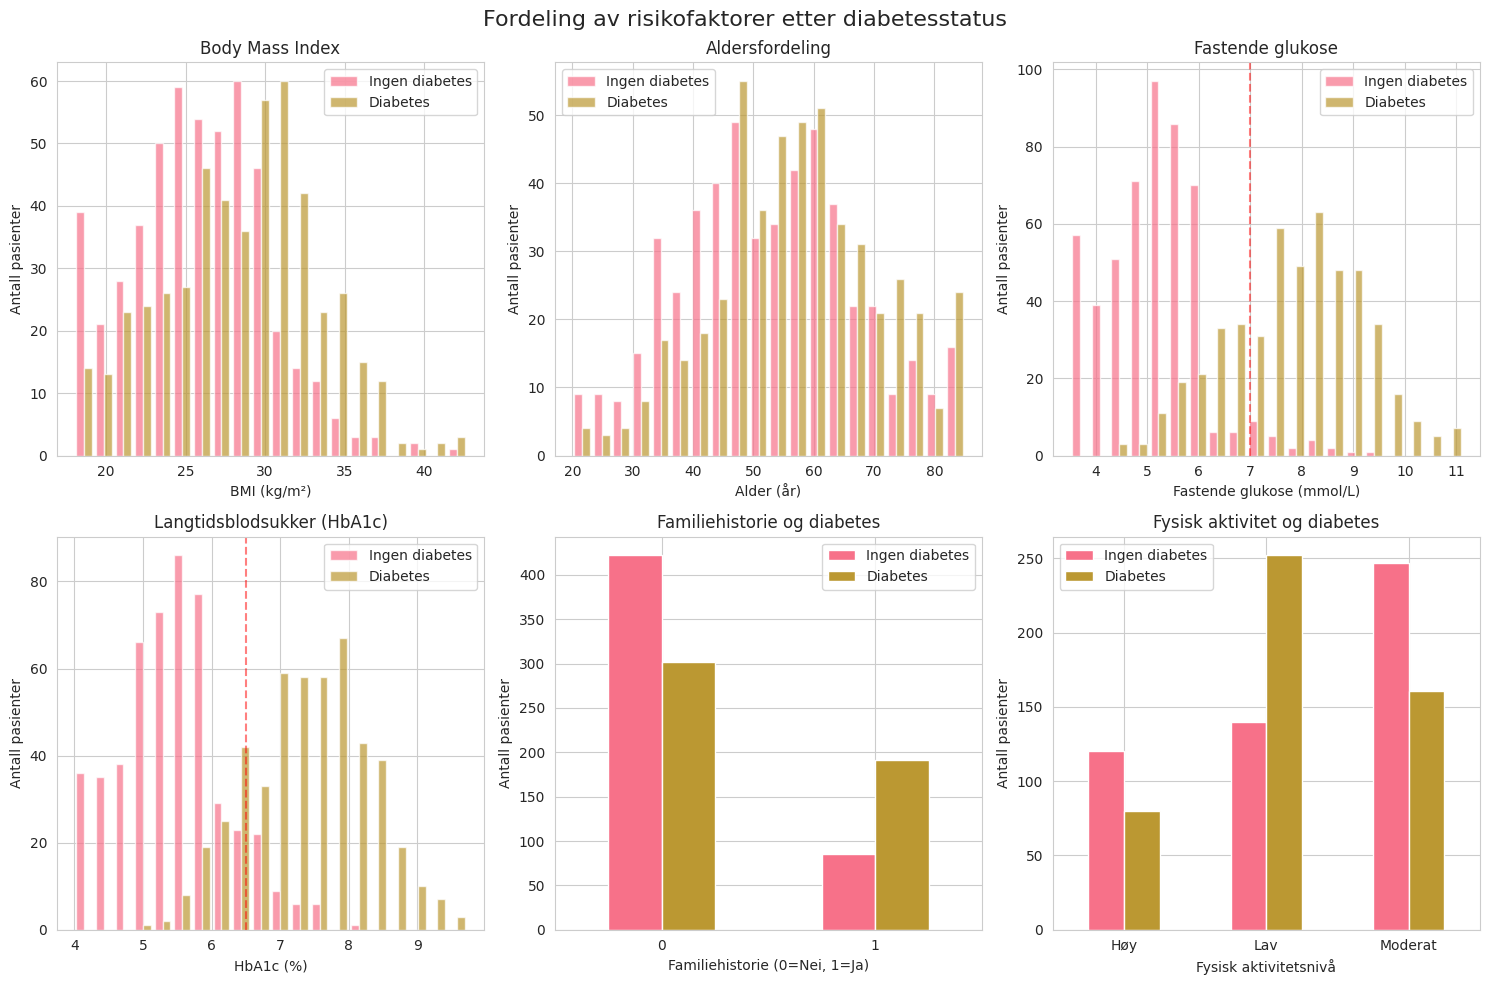


📊 Korrelasjonsanalyse:


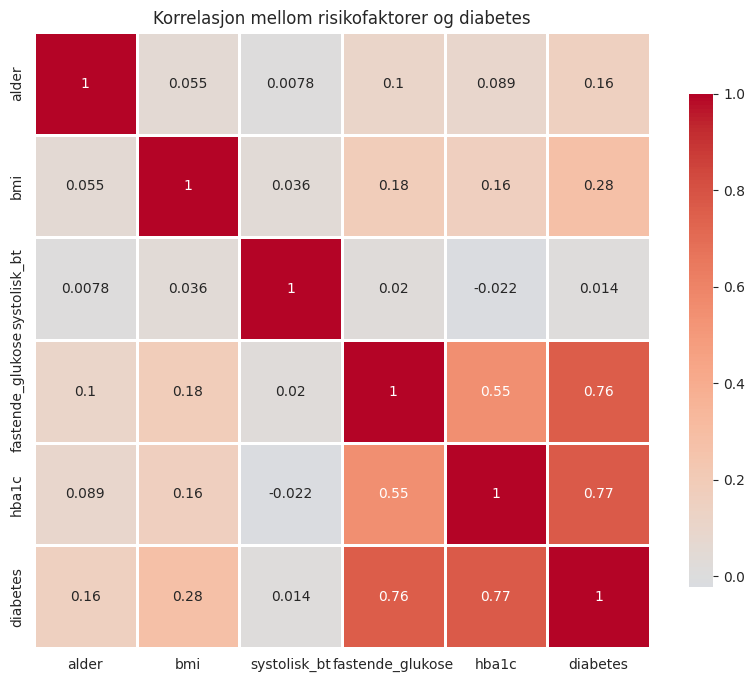

In [6]:
# Visualiser fordelingen av nøkkelvariabler
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Fordeling av risikofaktorer etter diabetesstatus', fontsize=16)

# BMI
axes[0,0].hist([df[df['diabetes']==0]['bmi'], df[df['diabetes']==1]['bmi']], 
               label=['Ingen diabetes', 'Diabetes'], alpha=0.7, bins=20)
axes[0,0].set_xlabel('BMI (kg/m²)')
axes[0,0].set_ylabel('Antall pasienter')
axes[0,0].legend()
axes[0,0].set_title('Body Mass Index')

# Alder
axes[0,1].hist([df[df['diabetes']==0]['alder'], df[df['diabetes']==1]['alder']], 
               label=['Ingen diabetes', 'Diabetes'], alpha=0.7, bins=20)
axes[0,1].set_xlabel('Alder (år)')
axes[0,1].set_ylabel('Antall pasienter')
axes[0,1].legend()
axes[0,1].set_title('Aldersfordeling')

# Fastende glukose
axes[0,2].hist([df[df['diabetes']==0]['fastende_glukose'], df[df['diabetes']==1]['fastende_glukose']], 
               label=['Ingen diabetes', 'Diabetes'], alpha=0.7, bins=20)
axes[0,2].set_xlabel('Fastende glukose (mmol/L)')
axes[0,2].set_ylabel('Antall pasienter')
axes[0,2].legend()
axes[0,2].set_title('Fastende glukose')
axes[0,2].axvline(x=7.0, color='red', linestyle='--', alpha=0.5, label='Diagnostisk grense')

# HbA1c
axes[1,0].hist([df[df['diabetes']==0]['hba1c'], df[df['diabetes']==1]['hba1c']], 
               label=['Ingen diabetes', 'Diabetes'], alpha=0.7, bins=20)
axes[1,0].set_xlabel('HbA1c (%)')
axes[1,0].set_ylabel('Antall pasienter')
axes[1,0].legend()
axes[1,0].set_title('Langtidsblodsukker (HbA1c)')
axes[1,0].axvline(x=6.5, color='red', linestyle='--', alpha=0.5, label='Diagnostisk grense')

# Familiehistorie
fam_hist = df.groupby(['familiehistorie', 'diabetes']).size().unstack()
fam_hist.plot(kind='bar', ax=axes[1,1], rot=0)
axes[1,1].set_xlabel('Familiehistorie (0=Nei, 1=Ja)')
axes[1,1].set_ylabel('Antall pasienter')
axes[1,1].set_title('Familiehistorie og diabetes')
axes[1,1].legend(['Ingen diabetes', 'Diabetes'])

# Fysisk aktivitet
fys_akt = df.groupby(['fysisk_aktivitet', 'diabetes']).size().unstack()
fys_akt.plot(kind='bar', ax=axes[1,2], rot=0)
axes[1,2].set_xlabel('Fysisk aktivitetsnivå')
axes[1,2].set_ylabel('Antall pasienter')
axes[1,2].set_title('Fysisk aktivitet og diabetes')
axes[1,2].legend(['Ingen diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

# Korrelasjonsmatrise
print("\n📊 Korrelasjonsanalyse:")
numeric_cols = ['alder', 'bmi', 'systolisk_bt', 'fastende_glukose', 'hba1c', 'diabetes']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Korrelasjon mellom risikofaktorer og diabetes')
plt.show()

## 🤖 Del 2: Bygge en prediktiv modell

### Steg 1: Forberede data for maskinlæring

In [7]:
# Forbered features og target
# Konverter kategoriske variabler til numeriske
df_ml = df.copy()
df_ml['kjonn_mann'] = (df_ml['kjonn'] == 'Mann').astype(int)
df_ml['fysisk_lav'] = (df_ml['fysisk_aktivitet'] == 'Lav').astype(int)
df_ml['fysisk_moderat'] = (df_ml['fysisk_aktivitet'] == 'Moderat').astype(int)

# Velg features for modellen
feature_columns = ['alder', 'kjonn_mann', 'bmi', 'systolisk_bt', 
                   'fastende_glukose', 'hba1c', 'familiehistorie',
                   'fysisk_lav', 'fysisk_moderat', 'royker']

X = df_ml[feature_columns]
y = df_ml['diabetes']

# Del opp i trenings- og testdata (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("📊 Datasett fordeling:")
print(f"Treningsdata: {len(X_train)} pasienter")
print(f"Testdata: {len(X_test)} pasienter")
print(f"\nDiabetes-prevalens:")
print(f"- Trening: {y_train.mean():.1%}")
print(f"- Test: {y_test.mean():.1%}")

📊 Datasett fordeling:
Treningsdata: 700 pasienter
Testdata: 300 pasienter

Diabetes-prevalens:
- Trening: 49.3%
- Test: 49.3%


### Steg 2: Tren et beslutningstre
Beslutningstrær er intuitive for helsepersonell fordi de følger en logisk hvis-så struktur,
lik kliniske retningslinjer.

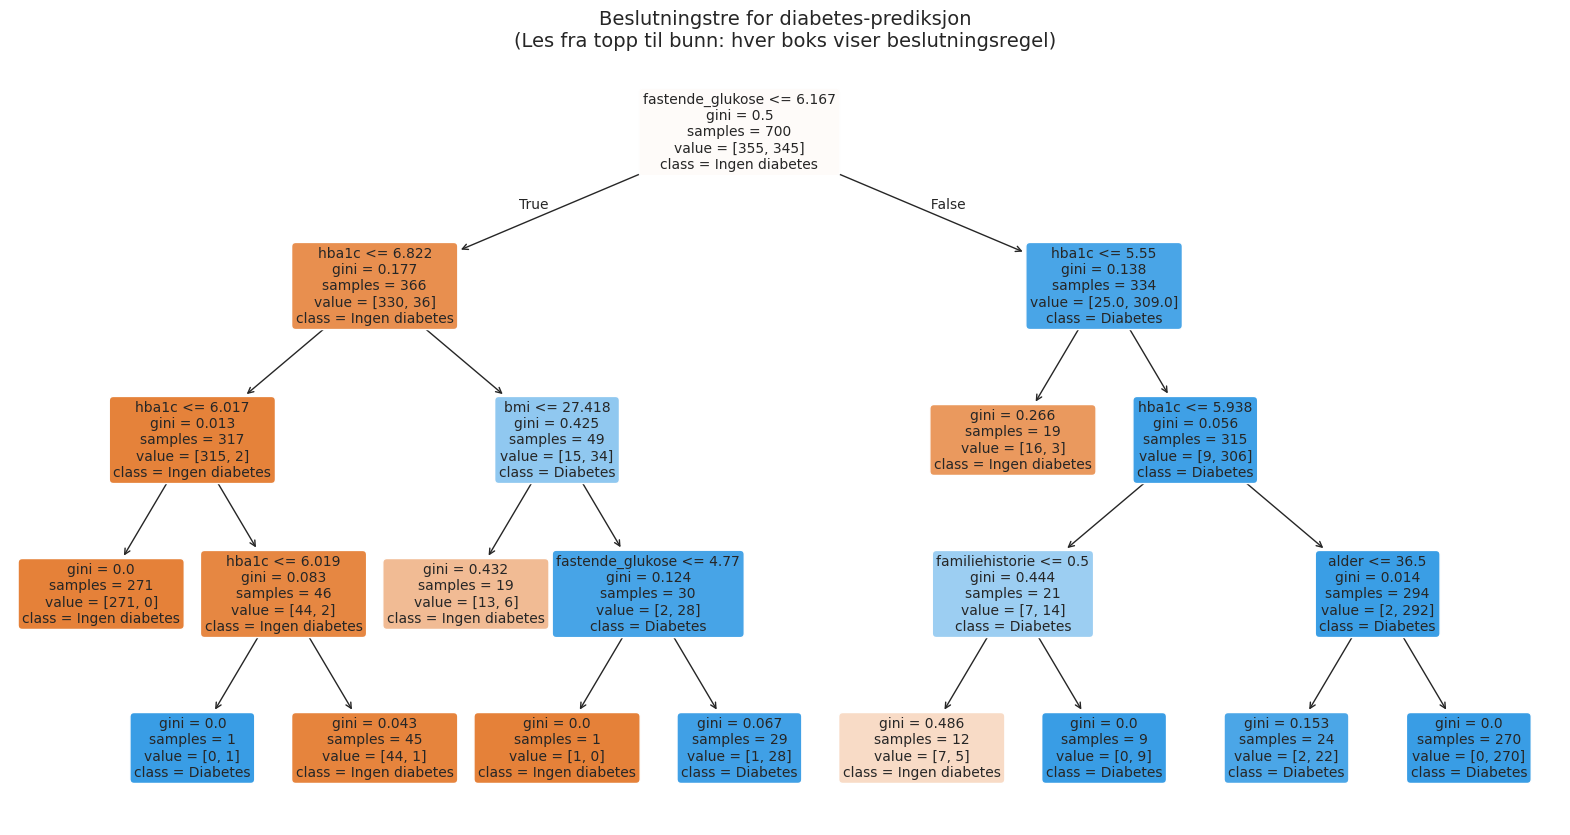

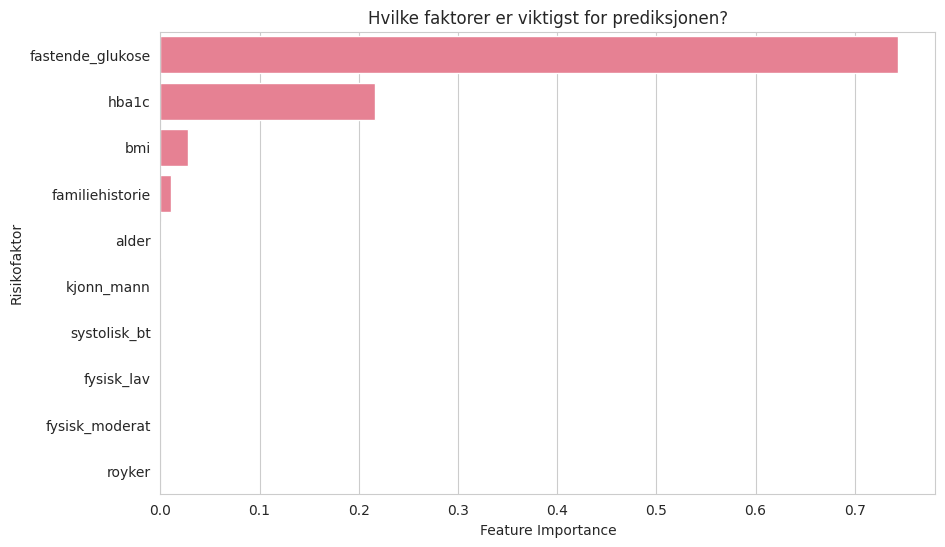

🔍 Top 3 viktigste risikofaktorer:
5. fastende_glukose: 0.744
6. hba1c: 0.217
3. bmi: 0.027


In [8]:
# Tren et beslutningstre
dt_model = DecisionTreeClassifier(
    max_depth=4,  # Begrens dybden for tolkbarhet
    min_samples_split=20,  # Minimum pasienter for splitting
    random_state=42
)

dt_model.fit(X_train, y_train)

# Visualiser beslutningstreet
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          feature_names=feature_columns,
          class_names=['Ingen diabetes', 'Diabetes'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Beslutningstre for diabetes-prediksjon\n(Les fra topp til bunn: hver boks viser beslutningsregel)', 
          fontsize=14)
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, y='feature', x='importance')
plt.title('Hvilke faktorer er viktigst for prediksjonen?')
plt.xlabel('Feature Importance')
plt.ylabel('Risikofaktor')
plt.show()

print("🔍 Top 3 viktigste risikofaktorer:")
for i, row in feature_importance.head(3).iterrows():
    print(f"{i+1}. {row['feature']}: {row['importance']:.3f}")

### Steg 3: Evaluere modellytelse
I medisin er det kritisk å forstå både sensitivitet (hvor mange syke vi fanger opp) 
og spesifisitet (hvor mange friske vi korrekt identifiserer).

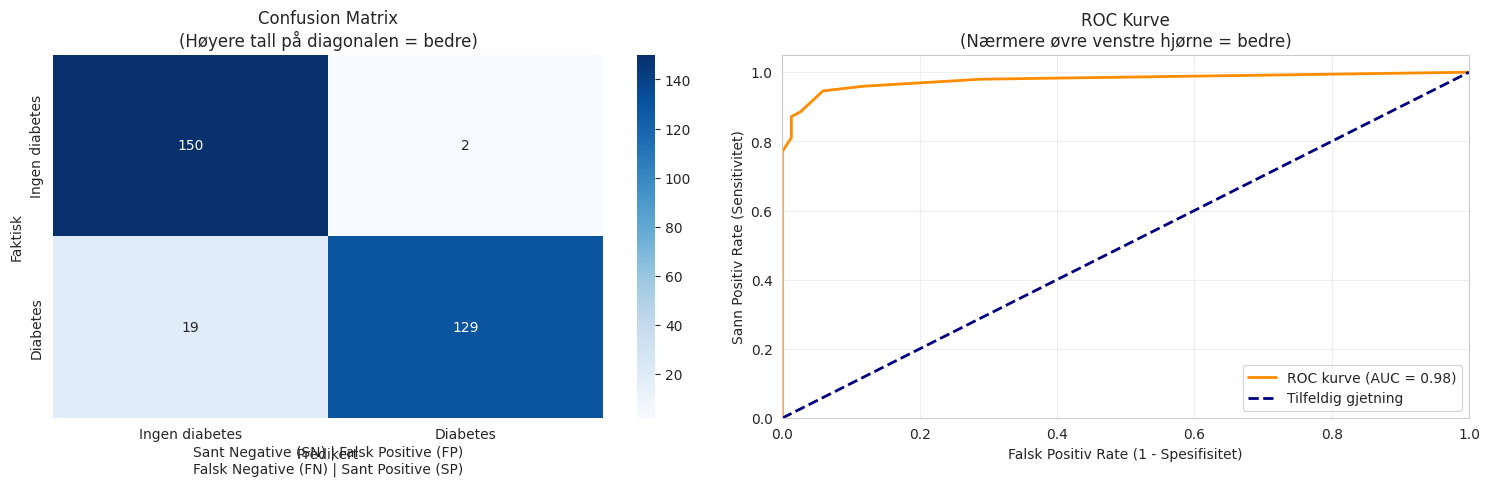


📊 Klassifikasjonsrapport:
                precision  recall  f1-score  support
Ingen diabetes       0.89    0.99      0.93   152.00
Diabetes             0.98    0.87      0.92   148.00
accuracy             0.93    0.93      0.93     0.93
macro avg            0.94    0.93      0.93   300.00
weighted avg         0.94    0.93      0.93   300.00

🏥 Klinisk relevante metrikker:
Sensitivitet (recall): 87.2%
  → Vi identifiserer 87.2% av alle med diabetes

Spesifisitet: 98.7%
  → Vi identifiserer korrekt 98.7% av de uten diabetes

Positiv prediktiv verdi (PPV): 98.5%
  → Hvis testen er positiv, er 98.5% sjanse for diabetes

Negativ prediktiv verdi (NPV): 88.8%
  → Hvis testen er negativ, er 88.8% sjanse for IKKE diabetes


In [9]:
# Prediksjoner på testdata
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Visualiser confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predikert')
axes[0].set_ylabel('Faktisk')
axes[0].set_title('Confusion Matrix\n(Høyere tall på diagonalen = bedre)')
axes[0].set_xticklabels(['Ingen diabetes', 'Diabetes'])
axes[0].set_yticklabels(['Ingen diabetes', 'Diabetes'])

# Legg til forklarende tekst
axes[0].text(0.5, -0.15, 'Sant Negative (SN) | Falsk Positive (FP)\n' + 
             'Falsk Negative (FN) | Sant Positive (SP)',
             transform=axes[0].transAxes, ha='center')

# ROC kurve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC kurve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Tilfeldig gjetning')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Falsk Positiv Rate (1 - Spesifisitet)')
axes[1].set_ylabel('Sann Positiv Rate (Sensitivitet)')
axes[1].set_title('ROC Kurve\n(Nærmere øvre venstre hjørne = bedre)')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detaljert klassifikasjonsrapport
print("\n📊 Klassifikasjonsrapport:")
print("="*50)
report = classification_report(y_test, y_pred, 
                              target_names=['Ingen diabetes', 'Diabetes'],
                              output_dict=True)

# Vis som DataFrame for bedre lesbarhet
report_df = pd.DataFrame(report).transpose()
print(report_df.round(2))

# Klinisk relevante metrikker
tn, fp, fn, tp = cm.ravel()
sensitivitet = tp / (tp + fn)
spesifisitet = tn / (tn + fp)
ppv = tp / (tp + fp)  # Positiv prediktiv verdi
npv = tn / (tn + fn)  # Negativ prediktiv verdi

print("\n🏥 Klinisk relevante metrikker:")
print("="*50)
print(f"Sensitivitet (recall): {sensitivitet:.1%}")
print(f"  → Vi identifiserer {sensitivitet:.1%} av alle med diabetes")
print(f"\nSpesifisitet: {spesifisitet:.1%}")
print(f"  → Vi identifiserer korrekt {spesifisitet:.1%} av de uten diabetes")
print(f"\nPositiv prediktiv verdi (PPV): {ppv:.1%}")
print(f"  → Hvis testen er positiv, er {ppv:.1%} sjanse for diabetes")
print(f"\nNegativ prediktiv verdi (NPV): {npv:.1%}")
print(f"  → Hvis testen er negativ, er {npv:.1%} sjanse for IKKE diabetes")

## 🌲 Del 3: Random Forest - En robust tilnærming

Random Forest kombinerer mange beslutningstrær for å gi mer robuste prediksjoner.
Dette er som å konsultere flere eksperter og ta gjennomsnittet av deres vurderinger.

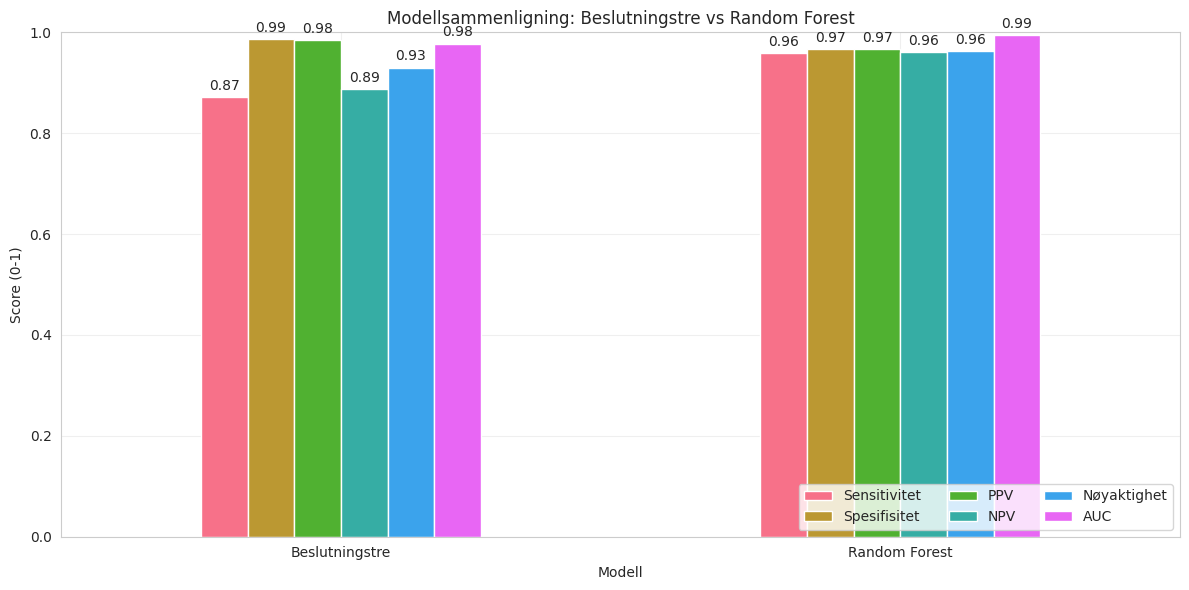

📊 Modellsammenligning:
                Sensitivitet  Spesifisitet    PPV    NPV  Nøyaktighet    AUC
Modell                                                                      
Beslutningstre         0.872         0.987  0.985  0.888        0.930  0.978
Random Forest          0.959         0.967  0.966  0.961        0.963  0.995


In [10]:
# Tren Random Forest modell
rf_model = RandomForestClassifier(
    n_estimators=100,  # Antall trær
    max_depth=5,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1  # Bruk alle CPU-kjerner
)

rf_model.fit(X_train, y_train)

# Sammenlign ytelse
models = {
    'Beslutningstre': dt_model,
    'Random Forest': rf_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Beregn metrikker
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.append({
        'Modell': name,
        'Sensitivitet': tp / (tp + fn),
        'Spesifisitet': tn / (tn + fp),
        'PPV': tp / (tp + fp),
        'NPV': tn / (tn + fn),
        'Nøyaktighet': (tp + tn) / (tp + tn + fp + fn),
        'AUC': auc(*roc_curve(y_test, y_pred_proba)[:2])
    })

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Modell')

# Visualiser sammenligning
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax)
plt.title('Modellsammenligning: Beslutningstre vs Random Forest')
plt.ylabel('Score (0-1)')
plt.xlabel('Modell')
plt.xticks(rotation=0)
plt.legend(loc='lower right', ncol=3)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

# Legg til verdier på søylene
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

print("📊 Modellsammenligning:")
print(results_df.round(3))

## 🔬 Del 4: Unsupervised Learning - Oppdage pasientgrupper

La oss bruke clustering for å identifisere naturlige pasientgrupper basert på risikoprofil.
Dette kan hjelpe med å tilpasse forebyggende tiltak.

🔬 Pasientgrupper identifisert med clustering:
         alder    bmi  fastende_glukose  hba1c  diabetes  familiehistorie  \
cluster                                                                     
0        54.62  27.12              6.30   6.26      0.39             0.24   
1        52.48  25.54              5.10   5.43      0.04             0.20   
2        56.66  28.47              7.85   7.41      0.99             0.38   

         royker  antall_pasienter  
cluster                            
0          0.22               408  
1          0.17               270  
2          0.21               322  


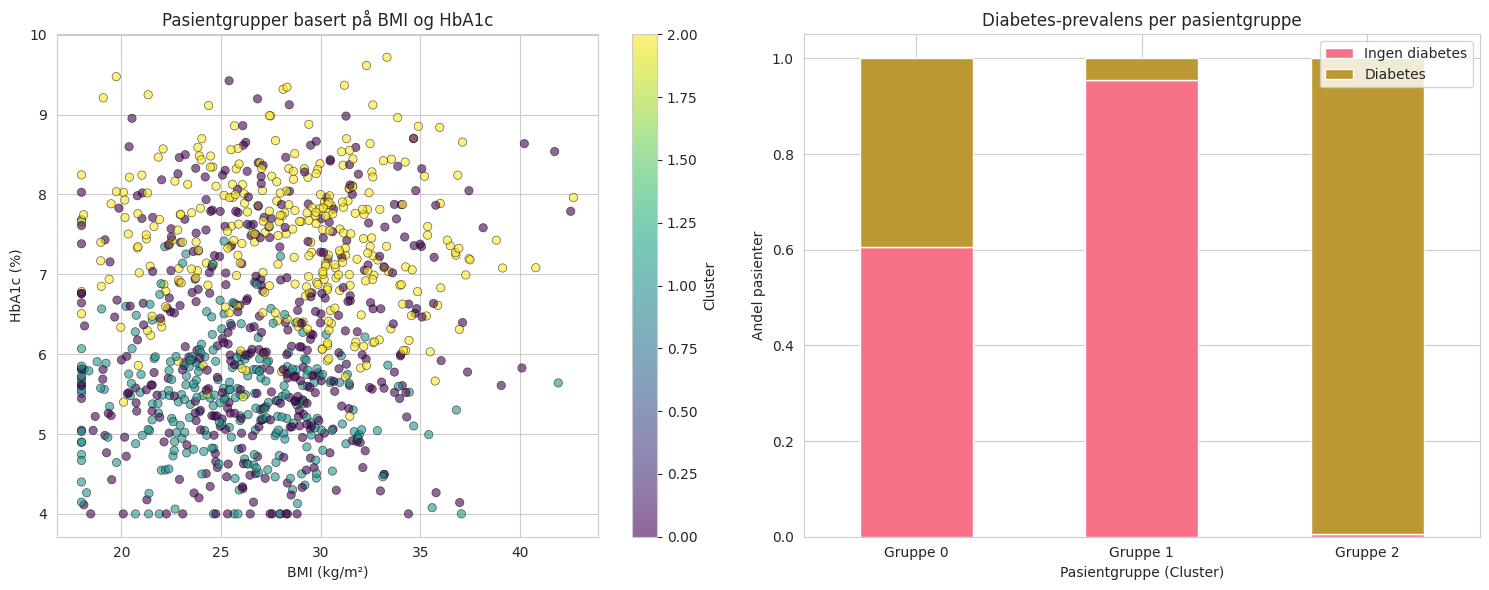


📋 Beskrivelse av pasientgrupper:

🏥 Gruppe 0:
  - Antall pasienter: 408
  - Gjennomsnittsalder: 55 år
  - Gjennomsnitt BMI: 27.1 kg/m²
  - Diabetes-prevalens: 39.0%
  → Risikovurdering: MODERAT RISIKO

🏥 Gruppe 1:
  - Antall pasienter: 270
  - Gjennomsnittsalder: 52 år
  - Gjennomsnitt BMI: 25.5 kg/m²
  - Diabetes-prevalens: 4.0%
  → Risikovurdering: LAV RISIKO

🏥 Gruppe 2:
  - Antall pasienter: 322
  - Gjennomsnittsalder: 57 år
  - Gjennomsnitt BMI: 28.5 kg/m²
  - Diabetes-prevalens: 99.0%
  → Risikovurdering: HØY RISIKO


In [11]:
# Standardiser data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Legg til cluster-informasjon til dataframe
df_ml['cluster'] = clusters

# Analyser cluster-karakteristikker
cluster_summary = df_ml.groupby('cluster').agg({
    'alder': 'mean',
    'bmi': 'mean',
    'fastende_glukose': 'mean',
    'hba1c': 'mean',
    'diabetes': 'mean',
    'familiehistorie': 'mean',
    'royker': 'mean'
}).round(2)

cluster_summary['antall_pasienter'] = df_ml.groupby('cluster').size()

print("🔬 Pasientgrupper identifisert med clustering:")
print("="*60)
print(cluster_summary)

# Visualiser clusters
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot av to viktige features
scatter = axes[0].scatter(df_ml['bmi'], df_ml['hba1c'], 
                         c=df_ml['cluster'], cmap='viridis', 
                         alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('BMI (kg/m²)')
axes[0].set_ylabel('HbA1c (%)')
axes[0].set_title('Pasientgrupper basert på BMI og HbA1c')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Diabetes-prevalens per cluster
cluster_diabetes = df_ml.groupby('cluster')['diabetes'].value_counts(normalize=True).unstack()
cluster_diabetes.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Pasientgruppe (Cluster)')
axes[1].set_ylabel('Andel pasienter')
axes[1].set_title('Diabetes-prevalens per pasientgruppe')
axes[1].legend(['Ingen diabetes', 'Diabetes'])
axes[1].set_xticklabels([f'Gruppe {i}' for i in range(3)], rotation=0)

plt.tight_layout()
plt.show()

# Beskriv hver gruppe
print("\n📋 Beskrivelse av pasientgrupper:")
print("="*60)
for i in range(3):
    cluster_data = cluster_summary.loc[i]
    print(f"\n🏥 Gruppe {i}:")
    print(f"  - Antall pasienter: {int(cluster_data['antall_pasienter'])}")
    print(f"  - Gjennomsnittsalder: {cluster_data['alder']:.0f} år")
    print(f"  - Gjennomsnitt BMI: {cluster_data['bmi']:.1f} kg/m²")
    print(f"  - Diabetes-prevalens: {cluster_data['diabetes']:.1%}")
    
    # Gi klinisk tolkning
    if cluster_data['diabetes'] < 0.2:
        risk = "LAV RISIKO"
    elif cluster_data['diabetes'] < 0.4:
        risk = "MODERAT RISIKO"
    else:
        risk = "HØY RISIKO"
    print(f"  → Risikovurdering: {risk}")

## 💡 Del 5: Klinisk anvendelse og tolkning

### Praktisk bruk av modellen for en ny pasient

In [12]:
def vurder_pasient(alder, kjonn, bmi, systolisk_bt, fastende_glukose, 
                   hba1c, familiehistorie, fysisk_aktivitet, royker):
    """
    Funksjon for å vurdere diabetesrisiko for en individuell pasient
    """
    # Forbered input data
    pasient_data = pd.DataFrame({
        'alder': [alder],
        'kjonn_mann': [1 if kjonn == 'Mann' else 0],
        'bmi': [bmi],
        'systolisk_bt': [systolisk_bt],
        'fastende_glukose': [fastende_glukose],
        'hba1c': [hba1c],
        'familiehistorie': [familiehistorie],
        'fysisk_lav': [1 if fysisk_aktivitet == 'Lav' else 0],
        'fysisk_moderat': [1 if fysisk_aktivitet == 'Moderat' else 0],
        'royker': [royker]
    })
    
    # Prediker med Random Forest
    risk_probability = rf_model.predict_proba(pasient_data)[0, 1]
    prediction = rf_model.predict(pasient_data)[0]
    
    # Generer rapport
    print("="*60)
    print("🏥 DIABETESRISIKOVURDERING")
    print("="*60)
    print("\n📋 Pasientinformasjon:")
    print(f"  Alder: {alder} år")
    print(f"  Kjønn: {kjonn}")
    print(f"  BMI: {bmi:.1f} kg/m²")
    print(f"  Fastende glukose: {fastende_glukose:.1f} mmol/L")
    print(f"  HbA1c: {hba1c:.1f}%")
    
    print("\n🎯 Risikovurdering:")
    print(f"  Sannsynlighet for diabetes: {risk_probability:.1%}")
    
    if risk_probability < 0.3:
        print("  → LAV RISIKO 🟢")
        print("\n📝 Anbefaling:")
        print("  - Oppretthold sunn livsstil")
        print("  - Årlig kontroll hos fastlege")
    elif risk_probability < 0.6:
        print("  → MODERAT RISIKO 🟡")
        print("\n📝 Anbefaling:")
        print("  - Livsstilsintervensjon anbefales")
        print("  - Kontroll hver 6. måned")
        print("  - Vurder henvisning til diabetesteam")
    else:
        print("  → HØY RISIKO 🔴")
        print("\n📝 Anbefaling:")
        print("  - Umiddelbar oppfølging nødvendig")
        print("  - Full diabetesutredning")
        print("  - Henvisning til spesialist vurderes")
    
    # Identifiser modifiserbare risikofaktorer
    print("\n🎯 Modifiserbare risikofaktorer:")
    if bmi > 30:
        print("  ⚠️ BMI > 30: Vektreduksjon anbefales")
    if fysisk_aktivitet == 'Lav':
        print("  ⚠️ Lav fysisk aktivitet: Øk til minimum 150 min/uke")
    if royker:
        print("  ⚠️ Røyking: Røykeslutt anbefales sterkt")
    
    return risk_probability

# Test med eksempelpasient
print("🧪 EKSEMPEL: Vurdering av testpasient\n")

risiko = vurder_pasient(
    alder=58,
    kjonn='Mann',
    bmi=31.5,
    systolisk_bt=145,
    fastende_glukose=6.8,
    hba1c=6.3,
    familiehistorie=1,
    fysisk_aktivitet='Lav',
    royker=0
)

🧪 EKSEMPEL: Vurdering av testpasient

🏥 DIABETESRISIKOVURDERING

📋 Pasientinformasjon:
  Alder: 58 år
  Kjønn: Mann
  BMI: 31.5 kg/m²
  Fastende glukose: 6.8 mmol/L
  HbA1c: 6.3%

🎯 Risikovurdering:
  Sannsynlighet for diabetes: 99.2%
  → HØY RISIKO 🔴

📝 Anbefaling:
  - Umiddelbar oppfølging nødvendig
  - Full diabetesutredning
  - Henvisning til spesialist vurderes

🎯 Modifiserbare risikofaktorer:
  ⚠️ BMI > 30: Vektreduksjon anbefales
  ⚠️ Lav fysisk aktivitet: Øk til minimum 150 min/uke


## 🎓 Oppsummering og refleksjon

### Hva har vi lært?

1. **Supervised Learning**: Beslutningstrær og Random Forest for diagnoseprediksjon
2. **Feature Importance**: Hvilke risikofaktorer som betyr mest
3. **Modell-evaluering**: Sensitivitet vs spesifisitet i klinisk kontekst
4. **Unsupervised Learning**: Identifisering av pasientgrupper
5. **Praktisk anvendelse**: Fra modell til klinisk beslutningsstøtte


## 📝 Refleksjonsspørsmål: Fra symptomer til diagnose

### 🧠 **Konseptuelle spørsmål**

1. **Sammenlign tradisjonelle diagnostiske tilnærminger med ML-baserte metoder:**
   - Hvilke fordeler og ulemper har maskinlæring sammenlignet med tradisjonelle kliniske retningslinjer?
   - Når ville du stole mer på en klinisk vurdering enn en ML-modell, og omvendt?

2. **Supervised vs. unsupervised læring:**
   - Forklar forskjellen mellom supervised og unsupervised læring med eksempler fra helsevesenet
   - Hvordan kan clustering (unsupervised) være nyttig for pasientbehandling selv om vi ikke predikerer en spesifikk diagnose?

### 🎯 **Modellforståelse og tolkbarhet**

3. **Beslutningstrær vs. Random Forest:**
   - Hvilken modell ville du anbefale til en kliniker som skal bruke systemet daglig? Begrunn svaret ditt.
   - Hvordan balanserer vi tolkbarhet mot nøyaktighet i kliniske AI-systemer?

4. **Feature importance og klinisk kunnskap:**
   - Var du overrasket over hvilke faktorer som var viktigst for modellen? Stemmer dette med etablert medisinsk kunnskap?
   - Hva ville du gjort hvis modellen vektla faktorer som ikke er klinisk anerkjent som viktige?

### 📊 **Evaluering og metrikker**

5. **Klinisk relevante metrikker:**
   - Forklar hvorfor sensitivitet og spesifisitet er særlig viktige i medisinsk diagnostikk
   - I hvilke situasjoner ville du prioritere høy sensitivitet over høy spesifisitet, og omvendt?

6. **Positiv og negativ prediktiv verdi:**
   - Hvordan påvirker sykdomsprevalens i befolkningen den positive og negative prediktive verdien?
   - Ville disse modellene fungere like godt i en befolkning med lavere diabetes-prevalens?

### 🏥 **Klinisk implementering**

7. **Pasientgrupper fra clustering:**
   - Hvordan kunne de identifiserte pasientgruppene (lav/moderat/høy risiko) brukes til å forbedre behandlingen?
   - Hvilke etiske hensyn bør tas ved bruk av algoritmisk pasientgruppering?

8. **Praktisk bruk i helsetjenesten:**
   - Hvilke barrierer ser du for å implementere slike modeller i norsk primærhelsetjeneste?
   - Hvordan ville du forberedt helsepersonell på å bruke AI-verktøy i sin praksis?

### 🤔 **Kritisk tenkning og begrensninger**

9. **Datasettkvalitet og bias:**
   - Hvilke begrensninger har det syntetiske datasettet brukt i denne øvelsen?
   - Hvilke typer bias kunne oppstått hvis dette var ekte pasientdata fra norske sykehus?

10. **Generalisering og robusthet:**
    - Hvor godt tror du denne modellen ville fungert på pasienter fra andre befolkningsgrupper eller land?
    - Hvilke faktorer kunne påvirke modellens ytelse over tid?

### 🔬 **Metodiske refleksjoner**

11. **Train/test split og overfitting:**
    - Hvorfor er det viktig å holde testdata separert under modellutvikling?
    - Hvilke tegn ville indikert at modellen var overfitted til treningsdataene?

12. **Feature engineering:**
    - Hvilke andre risikofaktorer for diabetes burde vært inkludert hvis tilgjengelig?
    - Hvordan påvirker måten vi koder kategoriske variabler modellens prestasjon?

### 🎓 **Sammenligning og fremtidige retninger**

13. **Klassisk ML vs. moderne metoder:**
    - Når ville du valgt enkle modeller som beslutningstrær over mer komplekse metoder som nevrale nettverk?
    - Hvilke fordeler har "klassisk" maskinlæring i kliniske settinger?

14. **Fremtidige forbedringer:**
    - Hvordan kunne denne tilnærmingen utvides til å inkludere andre datatyper (bilder, genetikk, kontinuerlig monitorering)?
    - Hvilke teknologiske eller metodiske fremskritt ser du som mest lovende for medisinsk diagnostikk?

### 💭 **Personlig refleksjon**

15. **Egen læring:**
    - Hvilket konsept eller metode fant du mest utfordrende å forstå?
    - Hvordan har denne øvelsen endret din forståelse av AI's rolle i helsevesenet?

16. **Etiske overveielser:**
    - Hvordan bør pasienter informeres om at AI brukes i deres diagnostikk?
    - Hvem bærer ansvaret hvis en AI-støttet diagnose er feil?

Disse spørsmålene er formulert for å fremme dybdeforståelse av både de tekniske aspektene ved maskinlæring og de praktiske utfordringene ved å implementere AI i helsevesenet. Hva er din refleksjon om dette?